d:\miniconda3\envs\pytorch312\Lib\site-packages\ignite\handlers\checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems


shape = torch.Size([1, 3, 300, 300])


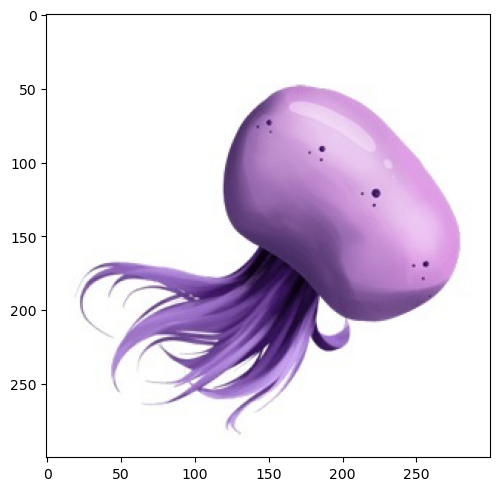

In [ ]:
from glio.imports import *
from glio.loaders.image import imreadtensor
from glio.transforms import znorm, norm
from glio2.plt_tools.plot import imshow
import glio2.nn as g2nn
import torchzero.nn as tznn
from torchzero.nn.functional.pad import pad_like
from torchzero.optim import QuadraticLS

image = znorm(imreadtensor(r"C:\Users\nkshv\Pictures\AA_AerofleetArt.jpg").to(torch.float32)).unsqueeze(0)
printa(shape = image.shape)
imshow(image,)

In [57]:
class Autoenc(nn.Module):
    def __init__(self, conv = g2nn.RFFTConv, upconv = g2nn.RFFTConvTranspose, act = nn.GELU):
        super().__init__()
        self.encoder = g2nn.Sequential(
            conv(3, 3, 3, 2, 1),
            act(),
            conv(3, 3, 3, 2, 1),
            act(),
            conv(3, 2, 3, 2, 1),
            act(),
            conv(2, 1, 3, 2, 1),
            act(),
        )
        self.decoder = g2nn.Sequential(
            upconv(1, 2, 3, 2, 1, 1),
            act(),
            upconv(2, 3, 3, 2, 1, 1),
            act(),
            upconv(3, 3, 3, 2, 1, 1),
            act(),
            upconv(3, 3, 3, 2, 1, 1),
        )
    def forward(self, x:torch.Tensor):
        x = self.encoder(x)
        x = self.decoder(x)
        return x[:, :, :300, :300]

image_cuda = image.to(CUDA)
model = Autoenc().to(CUDA)
#opt = QuadraticLS(model.parameters(), 1e-1, 1, 1)
#opt = torch.optim.LBFGS(model.parameters(), 1,)
opt = torch.optim.AdamW(model.parameters(), 1e-1,)
sched = lr_scheduler.OneCycleLR(opt, 1e-2, 1000)
loss = nn.MSELoss()

for i in range(1000):
    def closure(backward=True):
        opt.zero_grad()
        x = model(image_cuda)
        l = loss(x, image_cuda)
        if backward: l.backward()
        return l
    l = opt.step(closure)
    sched.step()
    if i % 100 == 0: print(l)

tensor(1.0000, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.6629, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1758, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1323, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1194, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1139, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1097, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1072, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1060, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1055, device='cuda:0', grad_fn=<MseLossBackward0>)


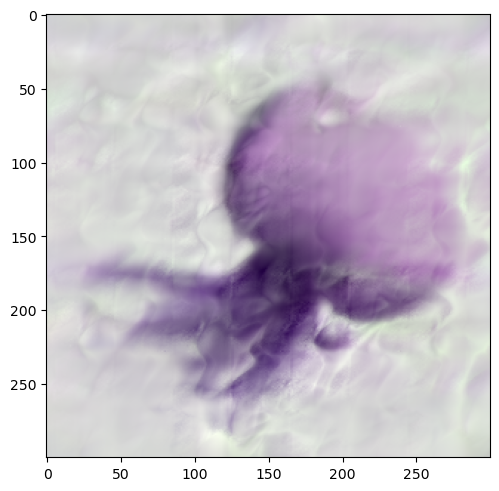

In [58]:
imshow(model(image_cuda))